In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from models.transformers import DecoderOnlyTransformer
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import yaml
import gc
import torch
from torchinfo import summary
import os
import json
import shutil
import wandb
import yaml
from data.datasets import CFGDataset, verify_dataloader
from trainers.GPT_trainer import GPT_Trainer
from trainers.utils import create_optimizer, create_scheduler




device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

#Read config yaml file
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
print(f"Config loaded successfully.")



Using device: cuda
Config loaded successfully.


#### Loading Data

In [2]:
train_dataset =  CFGDataset(
    data_file="cfg_sentences_train_cfg3b.pkl", 
    subset = config["data"]["subset"], 
    batch_size = config["data"]["batch_size"],
    seq_len = config["data"]["seq_len"],
    eos_token = config["data"]["eos_token"],
    sos_token = config["data"]["sos_token"],
    ) 

val_dataset =  CFGDataset(
    data_file="cfg_sentences_val_cfg3b.pkl", 
    subset = config["data"]["subset"], 
    batch_size = config["data"]["batch_size"],
    seq_len = config["data"]["seq_len"],
    eos_token = config["data"]["eos_token"],
    sos_token = config["data"]["sos_token"],
    ) 


train_loader = DataLoader(train_dataset, 
                          batch_size = None, 
                          num_workers=config["data"]["NUM_WORKERS"] if device == "cuda" else 0, 
                          pin_memory=True)

val_loader = DataLoader(val_dataset, 
                        batch_size=None, 
                        num_workers=config["data"]["NUM_WORKERS"] if device == "cuda" else 0,
                        pin_memory=True)

verify_dataloader(train_loader)
#print("="*50)
#print("Verify Validation DataLoader")
#verify_dataloader(val_loader)

7200000
800000
Verifying dataloader...
data subset:  1
Number of batches:  54
Total number of tokens:  1.440000e+07
Example batch shapes (shifted, golden):  torch.Size([512, 512]) torch.Size([512, 512])


In [4]:
model_config = {}
model_config = config['model'].copy()
print("Model Config : ", model_config)
model_config.update({
    'num_classes': config["data"]["vocab_size"] +2 ,#include SOS and ESO tolen
    'seq_len': config["data"]["seq_len"],
    })

model = DecoderOnlyTransformer(**model_config)

for batch in train_loader:
    shifted_transcripts, golden_transcripts = batch
    print("Shape of shifted_transcripts : ", shifted_transcripts.shape)
    print("Shape of golden_transcripts  : ", golden_transcripts.shape)
    break

#model_stats = summary(model, input_data=[shifted_transcripts])
#print(model_stats)
print("Total parameters in the model : ", sum(p.numel() for p in model.parameters()))

Model Config :  {'d_model': 10, 'd_ff': 10, 'num_layers': 1, 'num_heads': 10, 'dropout': 0.0, 'layer_drop_rate': 0.0, 'weight_tying': False}
Shape of shifted_transcripts :  torch.Size([512, 512])
Shape of golden_transcripts  :  torch.Size([512, 512])
Total parameters in the model :  825


In [5]:
trainer = GPT_Trainer(
    model = model, 
    config = config,
    config_file = "config.yaml",
    run_name = "test", 
    device = device
)

Using device: cuda



🔧 Configuring Optimizer:
├── Type: ADAMW
├── Base LR: 0.0007
├── Weight Decay: 0.1
├── Parameter Groups:
│   ├── Group: self_attn
│   │   ├── LR: 0.0007
│   │   └── Patterns: []
│   ├── Group: ffn
│   │   ├── LR: 0.0007
│   │   └── Patterns: []
│   └── Default Group (unmatched parameters)
└── AdamW Specific:
    ├── Betas: [0.9, 0.98]
    ├── Epsilon: 1e-08
    └── AMSGrad: False


/jet/home/sfragara/.conda/envs/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



📈 Configuring Learning Rate Scheduler:
├── Type: COSINE
├── Cosine Annealing Settings:
│   ├── T_max: 42 steps
│   └── Min LR: 1e-08
├── Warmup Settings:
│   ├── Duration: 5 epochs (210 steps)
│   ├── Start Factor: 0.1
│   └── End Factor: 1.0


/jet/home/sfragara/.conda/envs/env/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


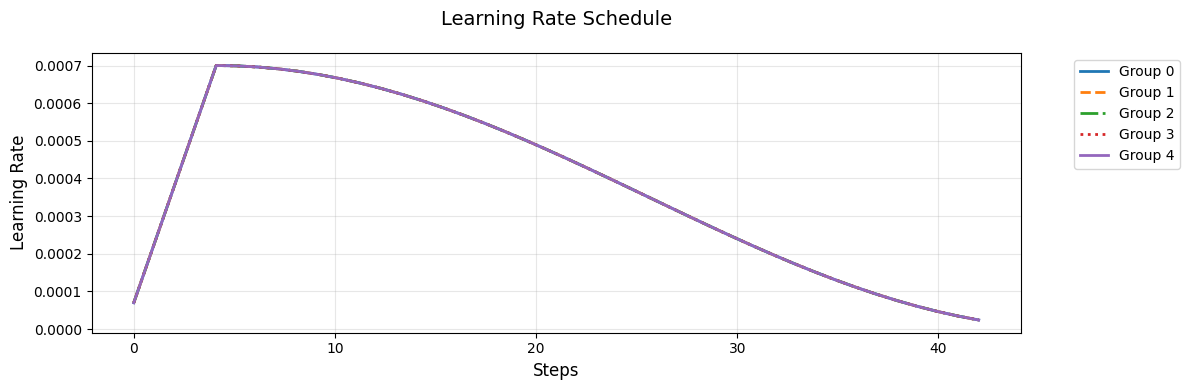

In [6]:
trainer.optimizer = create_optimizer.create_optimizer(
    model = model, 
    opt_config = config["optimizer"]
)

trainer.scheduler = create_scheduler.create_scheduler(
    optimizer=trainer.optimizer,
    scheduler_config=config['scheduler'],
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)


create_scheduler.plot_lr_schedule(
    scheduler=trainer.scheduler,
    num_epochs=len(train_loader),
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)



📊 Metrics (Epoch 0):
├── TRAIN:
│   ├── ce_loss_token: 2.0075
│   └── perplexity_token: 7.4445
└── VAL:
    ├── ce_loss_token: 2.0058
    └── perplexity_token: 7.4323
└── TRAINING:
    └── learning_rate: 0.000228



📊 Metrics (Epoch 1):
├── TRAIN:
│   ├── ce_loss_token: 2.0066
│   └── perplexity_token: 7.4377
└── VAL:
    ├── ce_loss_token: 2.0020
    └── perplexity_token: 7.4035
└── TRAINING:
    └── learning_rate: 0.000385



📊 Metrics (Epoch 2):
├── TRAIN:
│   ├── ce_loss_token: 2.0049
│   └── perplexity_token: 7.4257
└── VAL:
    ├── ce_loss_token: 1.9954
    └── perplexity_token: 7.3552
└── TRAINING:
    └── learning_rate: 0.000543


/jet/home/sfragara/.conda/envs/env/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



📊 Metrics (Epoch 3):
├── TRAIN:
│   ├── ce_loss_token: 2.0025
│   └── perplexity_token: 7.4078
└── VAL:
    ├── ce_loss_token: 1.9862
    └── perplexity_token: 7.2881
└── TRAINING:
    └── learning_rate: 0.000700



📊 Metrics (Epoch 4):
├── TRAIN:
│   ├── ce_loss_token: 1.9992
│   └── perplexity_token: 7.3833
└── VAL:
    ├── ce_loss_token: 1.9745
    └── perplexity_token: 7.2029
└── TRAINING:
    └── learning_rate: 0.000699



📊 Metrics (Epoch 5):
├── TRAIN:
│   ├── ce_loss_token: 1.9951
│   └── perplexity_token: 7.3526
└── VAL:
    ├── ce_loss_token: 1.9629
    └── perplexity_token: 7.1196
└── TRAINING:
    └── learning_rate: 0.000696



📊 Metrics (Epoch 6):
├── TRAIN:
│   ├── ce_loss_token: 1.9904
│   └── perplexity_token: 7.3186
└── VAL:
    ├── ce_loss_token: 1.9514
    └── perplexity_token: 7.0383
└── TRAINING:
    └── learning_rate: 0.000691



📊 Metrics (Epoch 7):
├── TRAIN:
│   ├── ce_loss_token: 1.9856
│   └── perplexity_token: 7.2832
└── VAL:
    ├── ce_loss_token: 1.9401
    └── perplexity_token: 6.9592
└── TRAINING:
    └── learning_rate: 0.000684



📊 Metrics (Epoch 8):
├── TRAIN:
│   ├── ce_loss_token: 1.9806
│   └── perplexity_token: 7.2469
└── VAL:
    ├── ce_loss_token: 1.9290
    └── perplexity_token: 6.8825
└── TRAINING:
    └── learning_rate: 0.000676



📊 Metrics (Epoch 9):
├── TRAIN:
│   ├── ce_loss_token: 1.9754
│   └── perplexity_token: 7.2096
└── VAL:
    ├── ce_loss_token: 1.9181
    └── perplexity_token: 6.8082
└── TRAINING:
    └── learning_rate: 0.000665



📊 Metrics (Epoch 10):
├── TRAIN:
│   ├── ce_loss_token: 1.9702
│   └── perplexity_token: 7.1721
└── VAL:
    ├── ce_loss_token: 1.9075
    └── perplexity_token: 6.7366
└── TRAINING:
    └── learning_rate: 0.000653



📊 Metrics (Epoch 11):
├── TRAIN:
│   ├── ce_loss_token: 1.9650
│   └── perplexity_token: 7.1349
└── VAL:
    ├── ce_loss_token: 1.8973
    └── perplexity_token: 6.6675
└── TRAINING:
    └── learning_rate: 0.000639


KeyboardInterrupt: 

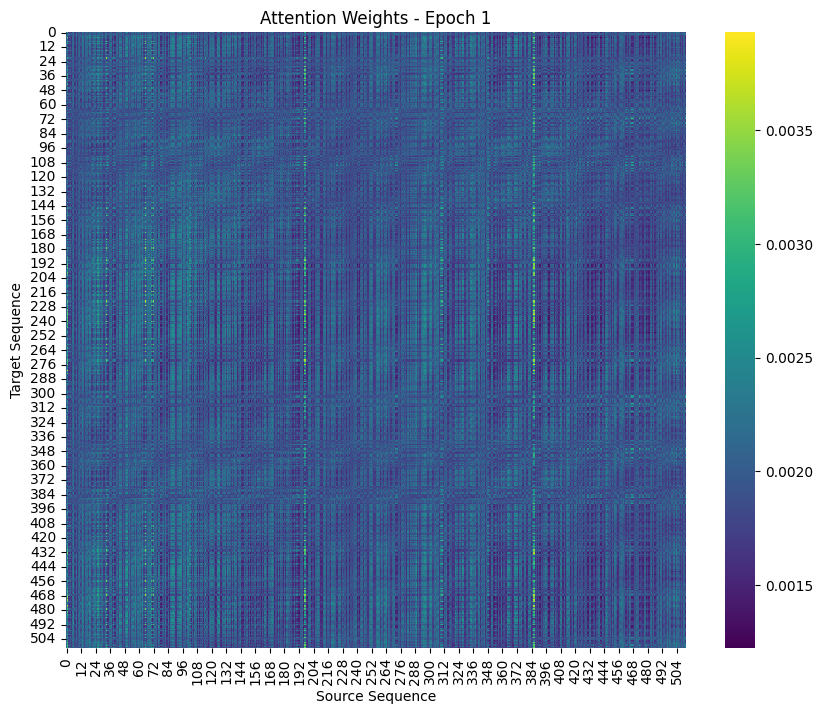

In [7]:
trainer.train_epoch(
    train_dataloader=train_loader,
    val_dataloader=val_loader,
)